In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from typing import Tuple
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
# Set the directories for training and validation images
train_images_dir = "/Users/hritikkumar/Downloads/Brain_data/Training"
val_images_dir = "/Users/hritikkumar/Downloads/Brain_data/Testing"

In [5]:
# Function to get images from directory
def get_images(dir: str) -> keras.preprocessing.image.DirectoryIterator:
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

    batch_size = 16
    img_height = 128    
    img_width = 128

    dataset = datagen.flow_from_directory(
        dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
    )

    return dataset

In [7]:
# Load training and validation data
train_data = get_images(train_images_dir)
val_data = get_images(val_images_dir)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [9]:
# Function to plot a batch of images
def plot_batch(data: keras.preprocessing.image.DirectoryIterator, model_to_predict=None, title=None):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 8))
    imgs, labels = next(data)  # Get one batch
    classes = list(data.class_indices.keys())
    
    for i, (img, label) in enumerate(zip(imgs, labels)):
        ax = axes[i // 4, i % 4]
        ax.imshow(img)
        index = label.argmax()
        real = classes[index]
        
        if model_to_predict is not None:
            predictions = model_to_predict.predict(x=imgs, verbose=0)
            index = predictions[i].argmax()
            pred = classes[index]
            ax.set_title(f"Real: {real} \n Pred: {pred}") 
        else:
            ax.set_title(real)
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

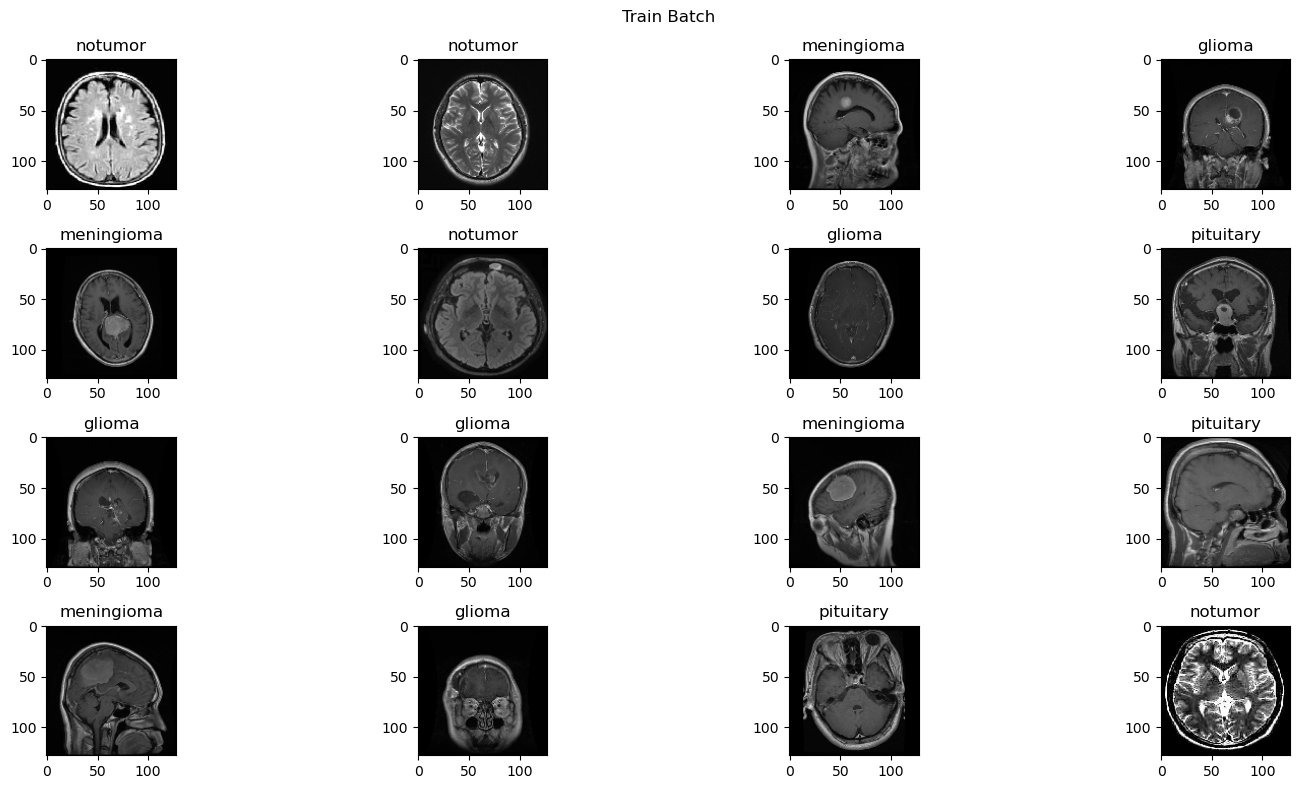

In [11]:
# Plot a batch of training images
plot_batch(train_data, title="Train Batch")

In [13]:
# Set random seed for reproducibility
tf.random.set_seed(42)

In [15]:
# Build the model
model = Sequential([
    Conv2D(input_shape=(128, 128, 3), filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(rate=0.2),
    Dense(units=len(train_data.class_indices), activation='softmax')  # Change to number of classes
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

In [19]:
# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=20, verbose=2)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 - 25s - 70ms/step - accuracy: 0.7204 - loss: 0.6951 - val_accuracy: 0.7857 - val_loss: 0.5208
Epoch 2/20
357/357 - 30s - 84ms/step - accuracy: 0.8536 - loss: 0.3825 - val_accuracy: 0.8467 - val_loss: 0.3725
Epoch 3/20
357/357 - 27s - 76ms/step - accuracy: 0.8922 - loss: 0.2865 - val_accuracy: 0.8856 - val_loss: 0.2521
Epoch 4/20
357/357 - 26s - 74ms/step - accuracy: 0.9186 - loss: 0.2185 - val_accuracy: 0.9230 - val_loss: 0.1927
Epoch 5/20
357/357 - 28s - 80ms/step - accuracy: 0.9443 - loss: 0.1577 - val_accuracy: 0.9314 - val_loss: 0.1900
Epoch 6/20
357/357 - 27s - 77ms/step - accuracy: 0.9576 - loss: 0.1104 - val_accuracy: 0.9443 - val_loss: 0.1700
Epoch 7/20
357/357 - 26s - 74ms/step - accuracy: 0.9618 - loss: 0.1006 - val_accuracy: 0.9542 - val_loss: 0.1381
Epoch 8/20
357/357 - 26s - 73ms/step - accuracy: 0.9709 - loss: 0.0770 - val_accuracy: 0.9390 - val_loss: 0.2187
Epoch 9/20
357/357 - 26s - 74ms/step - accuracy: 0.9744 - loss: 0.0682 - val_accuracy: 0.9611 - val_loss: 0

In [21]:
# Function to plot training history
def plot_training_history(history, figsize=(12, 4)):
    plt.figure(figsize=figsize)
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.show()

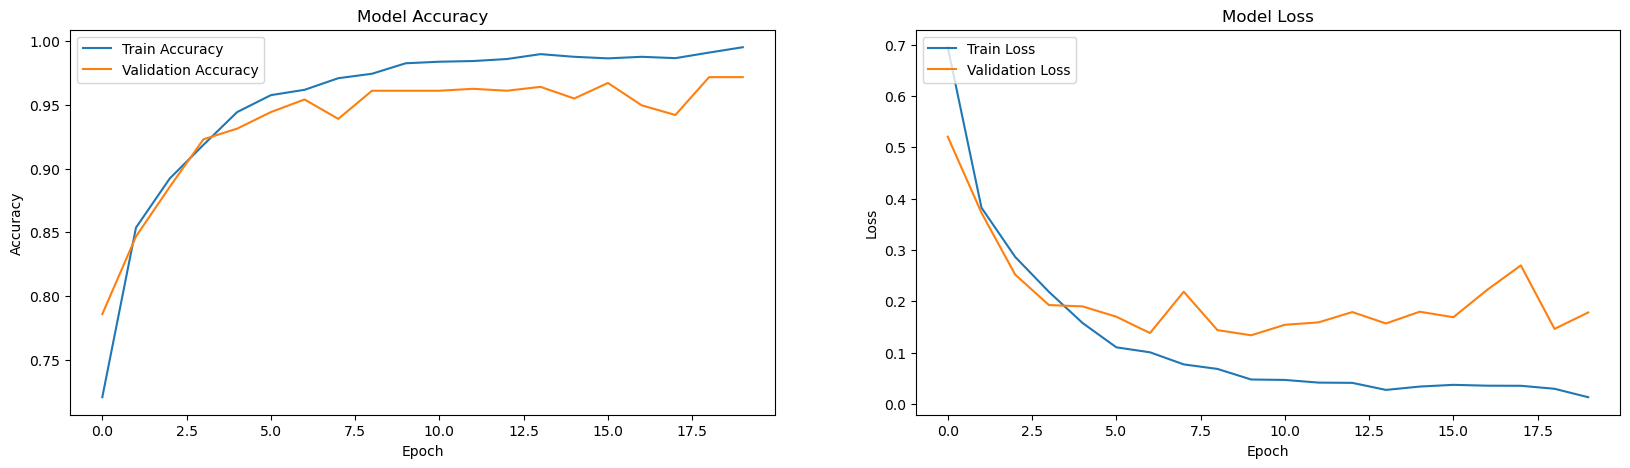

In [23]:
# Plot the training history
plot_training_history(history, (20, 5))

In [25]:
# Function to extract data from the iterator
def extract_iterator_data(data_iterator: keras.preprocessing.image.DirectoryIterator, batch_size: int=16) -> Tuple[np.ndarray, np.ndarray]:
    data_iterator.reset()
    n = data_iterator.samples

    X, y = next(data_iterator)
    for _ in tqdm(range(int(n / batch_size) - 1)):
        img, label = next(data_iterator)
        X = np.append(X, img, axis=0)
        y = np.append(y, label, axis=0)
  
    return X, y

In [27]:
# Extract validation data
x_test, y_test = extract_iterator_data(val_data)

100%|███████████████████████████████████████████| 80/80 [00:02<00:00, 26.79it/s]


In [29]:
# Evaluate the model
model.evaluate(x=x_test, y=y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9765 - loss: 0.1812


[0.18035170435905457, 0.9714506268501282]

In [31]:
# Predictions and confusion matrix
y_pred_probabilities = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [33]:
# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

In [35]:
# Create class names for the report and confusion matrix
class_names = list(train_data.class_indices.keys())

In [37]:
# Print classification report for precision, recall, and F1 score
report = classification_report(y_true_classes, y_pred_classes, target_names=list(train_data.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       297
  meningioma       0.93      0.95      0.94       300
     notumor       0.99      1.00      0.99       402
   pituitary       0.99      1.00      0.99       297

    accuracy                           0.97      1296
   macro avg       0.97      0.97      0.97      1296
weighted avg       0.97      0.97      0.97      1296



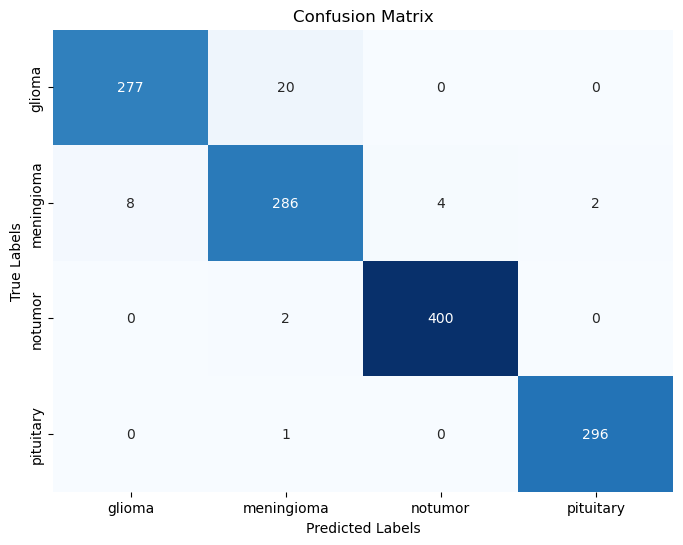

In [39]:
# Plot the confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()